## DL Ops Assignment 4
### Question 1
#### Submitted by - Debonil Ghosh [ M21AIE225 ]

In [36]:
import pandas as pd
import torch
import torch.nn
import torch.optim
import torch.utils.data
import torchvision.datasets
import torchvision.models
import torchvision.transforms as T
from sklearn import metrics
import seaborn as sns
import time
import math
import numpy as np
import matplotlib.pyplot as plt
print('Starting ...')



Starting ...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Available device ==> {device}')



Available device ==> cuda:0


In [13]:


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



In [31]:
# Train the model
def model_training(model, criterion, optimizer, trainloader, testloader, num_epochs=10, model_name='model'):
    start = time.time()
    loss_list = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            #print(outputs.shape)
            #print(labels.shape)
            loss = criterion(outputs, labels)
            #print(loss.item())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += metrics.accuracy_score(labels.cpu().detach(
            ).numpy(), outputs.cpu().detach().numpy().argmax(axis=1))
        # Evaluate the model on the validation set
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += metrics.accuracy_score(labels.cpu().detach(
                ).numpy(), outputs.cpu().detach().numpy().argmax(axis=1))
        train_loss = train_loss/len(trainloader)
        val_loss = val_loss/len(testloader)
        train_acc = train_acc/len(trainloader)
        val_acc = val_acc/len(testloader)
        print(f'Epoch: {epoch+1} ({timeSince(start)}) \tTraining Loss: {train_loss:.3f}, \tTest Loss: {val_loss:.3f},  \tTraining acc: {train_acc:.3f}, \tTest acc: {val_acc:.3f}, ', flush=True)
        loss_list.append([train_loss, val_loss, train_acc, val_acc])

    print(
        f'Training completed in {timeSince(start)} \tTraining Loss: {loss_list[-1][0]:.3f}, \tTest Loss: {loss_list[-1][1]:.3f},  \tTraining acc: {loss_list[-1][2]:.2f}, \tTest acc: {loss_list[-1][3]:.2f}, ')
    return np.array(loss_list), time.time()-start, loss_list[-1][2], loss_list[-1][3]



In [33]:
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})


def confusionMatrixAndAccuracyReport(Y_test, Y_pred, classes, title=''):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = metrics.accuracy_score(Y_test, Y_pred)

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    f1_score = metrics.f1_score(Y_test, Y_pred, average='weighted')
    f1_score_classwise = metrics.f1_score(Y_test, Y_pred, average=None)

    plt.figure(figsize=(20, 20))
    plt.title(
        f'{title} : Accuracy : {overallAccuracy*100:3.2f}% | F1 Score : {f1_score*100:3.2f}% ', size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues',
                fmt='g', xticklabels=classes, yticklabels=classes)

    plt.show()
    plt.savefig(
        f'confusion_mat_{title}_{time.time()}.png', bbox_inches='tight')
    print(f'Accuracy: {overallAccuracy*100:3.3f}%')
    print(f'F1 Score: {f1_score*100:3.3f}%')
    classwiseAccuracy_df = pd.DataFrame(
        data=[classwiseAccuracy], columns=classes)
    print(
        f'\nClasswise Accuracy Score: \n{classwiseAccuracy_df.to_markdown(index=False)}')
    f1_score_classwise_df = pd.DataFrame(
        data=[f1_score_classwise], columns=classes)
    print(
        f'\nClasswise F1 Score: \n{f1_score_classwise_df.to_markdown(index=False)}')
    f1_score_classwise_df.to_csv(f'classwise_f1_score_{title}.csv',index=False)
    print('\nConfusion Matrix:')
    print(cm.to_markdown())



In [16]:
def plot_training_graphs(loss_list, title=''):
    fig = plt.figure(figsize=(20, 7))
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title(f"{title} : Training vs Validation loss")
    plot.plot(loss_list[:, 0], linestyle='--', label="Training Loss")
    plot.plot(loss_list[:, 1], linestyle='-', label="Validation Loss")
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Loss")
    plot.legend()
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title(f"{title} : Training vs Validation Accuracy")
    plot.plot(loss_list[:, 2], linestyle='--', label="Training Accuracy")
    plot.plot(loss_list[:, 3], linestyle='-', label="Validation Accuracy")
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Accuracy")
    plot.legend()
    plt.show()
    plt.savefig(
        f'training_loss_{title}_{time.time()}.png', bbox_inches='tight')



In [8]:


def view_samples(testloader, classes):

    test_images, labels = next(iter(testloader))
    print(test_images.shape)
    fig = plt.figure(figsize=(20, 7))
    nrows = 3
    ncols = 10
    b = np.random.randint(0, test_images.shape[0]-nrows*ncols)
    for i in range(nrows*ncols):
        plot = fig.add_subplot(nrows, ncols, i+1)
        plot.set_title(classes[labels[i+b].cpu().numpy()])
        plot.imshow(np.transpose(test_images[i+b], (1, 2, 0)).cpu())
    plt.show()
    plt.savefig(f'view_samples_{time.time()}.png', bbox_inches='tight')

def view_samples2(train_set, classes):

    test_images, labels = train_set.np_imgs,train_set.targets
    print(test_images.shape)
    print(labels.shape)
    nrows = 10 #len(classes)
    ncols = 10
    fig = plt.figure(figsize=(20, nrows*2))
    b = np.random.randint(0, 1999)
    for cls in range(nrows):
      for i in range(ncols):
          img_idx = cls*2000+i+b
          #print(cls,i,img_idx)
          #print(classes[labels[img_idx]])
          #print(test_images[img_idx].shape)
          plot = fig.add_subplot(nrows, ncols, cls*nrows +i+1)
          plot.set_title(classes[labels[img_idx]])
          plot.imshow((test_images[img_idx]))
    plt.show()
def filter_dataset(dataset_full):
    # Selecting even classes 0,2,4,6,8 as roll number is odd (M21AIE225)
    targets = np.array(dataset_full.targets)
    idx = (targets == 0) | (targets == 2) | (
        targets == 4) | (targets == 6) | (targets == 8)
    dataset_full.targets = np.rint(targets[idx]/2).astype(int)
    dataset_full.data = dataset_full.data[idx]
    dataset_full.classes = [dataset_full.classes[c] for c in [0, 2, 4, 6, 8]]
    return dataset_full



In [6]:
from torch.utils.data import Dataset
import pandas as pd
class CustomDataset(Dataset):
    def __init__(self, csv_path, transform=None,train = True):
        self.transform = transform
        df = pd.read_csv(csv_path).dropna() #.sample(frac=0.8 if train else 0.2)
        self.classes = np.sort(df['character'].unique())
        self.class_to_idx = {k: v for v, k in enumerate(self.classes)}
        self.labels = df['character'].values
        mapper_fn = lambda x: self.class_to_idx[x]
        self.targets = np.vectorize(mapper_fn)(self.labels)
        self.np_imgs = df.drop('character',axis=1).apply(lambda x: np.array(x,dtype=np.float32).reshape((32,32)), axis=1).values
        
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        image = self.np_imgs[idx]
        
        label = self.targets[idx]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long, device=device)

Data Loading ...
torch.Size([64, 1, 32, 32])


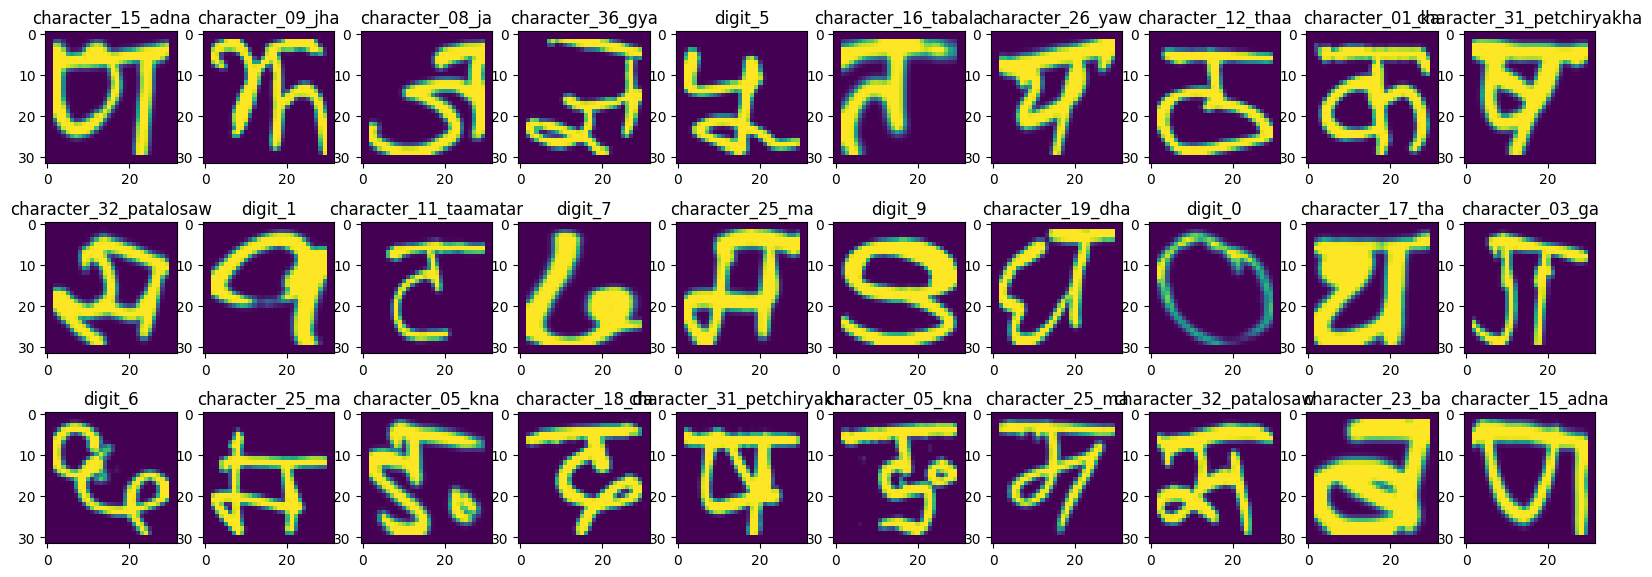

Train data size : 92000
Test data size : 92000
Train data classes : 46
Test data classes : 46
Data Loading Done !


<Figure size 640x480 with 0 Axes>

In [17]:
print('Data Loading ...')
csv_path='drive/MyDrive/GAN_data.csv'
transform = T.Compose([T.ToTensor(),T.Normalize((0.5,), (0.5,))]) # T.Resize(64,antialias=False),

train_set = CustomDataset(csv_path=csv_path, transform=transform,train=True)
trainloader = torch.utils.data.DataLoader(
    train_set, batch_size=64, shuffle=True)

test_set = CustomDataset(csv_path=csv_path, transform=transform,train=False)
testloader = torch.utils.data.DataLoader(
    test_set, batch_size=64, shuffle=True)

view_samples(testloader, test_set.classes)
print(f'Train data size : {train_set.np_imgs.shape[0]}')
print(f'Test data size : {test_set.np_imgs.shape[0]}')
print(f'Train data classes : {train_set.classes.shape[0]}')
print(f'Test data classes : {test_set.classes.shape[0]}')
print('Data Loading Done !')


# **Hyperparameter** for Conditional DC Gan Training

In [ ]:
img_size = test_set.np_imgs.shape[0]

NUM_EPOCH = 10 
size_z = 100
Ksteps = 1 
Adam_lr = 0.0002 
Adam_beta1 = 0.5 
BATCH_SIZE = 128

## Discriminator Model ( D )


In [ ]:
import torch.nn as nn
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.layer_x = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32,
                                           kernel_size=4, stride=2, padding=1, bias=False),
                                 nn.LeakyReLU(0.2, inplace=True),
                                )
                                 
    self.layer_y = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=32,
                                           kernel_size=4, stride=2, padding=1, bias=False),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 )
    self.layer_xy = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                            kernel_size=4, stride=2, padding=1, bias=False),
                               nn.BatchNorm2d(128),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Conv2d(in_channels=128, out_channels=256,
                                         kernel_size=3, stride=2, padding=0, bias=False),
                               nn.BatchNorm2d(256),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Conv2d(in_channels=256, out_channels=1,
                                         kernel_size=3, stride=1, padding=0, bias=False),
                               nn.Sigmoid()
                               )
  
  def forward(self, x, y):
    x = self.layer_x(x)
    y = self.layer_y(y)
    xy = torch.cat([x,y], dim=1)
    xy = self.layer_xy(xy)
    xy = xy.view(xy.shape[0], -1)
    return xy

In [ ]:

netD = Discriminator().to(device)
print(netD)

Discriminator(
  (layer_x): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer_y): Sequential(
    (0): Conv2d(10, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer_xy): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): Sigmoid()
  )
)


## Generator Model ( G )



In [ ]:
class Generator(nn.Module):
  def __init__(self, input_size=100):
    super(Generator, self).__init__()

    self.layer_x = nn.Sequential(nn.ConvTranspose2d(in_channels=size_z, out_channels=128, kernel_size=3,
                                                  stride=1, padding=0, bias=False),
                                 nn.BatchNorm2d(128),
                                 nn.ReLU(),
                                )
    
    self.layer_y = nn.Sequential(nn.ConvTranspose2d(in_channels=10, out_channels=128, kernel_size=3,
                                                  stride=1, padding=0, bias=False),
                                 nn.BatchNorm2d(128),
                                 nn.ReLU(),
                                )
    
    self.layer_xy = nn.Sequential(nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3,
                                                  stride=2, padding=0, bias=False),
                               nn.BatchNorm2d(128),
                               nn.ReLU(),
                               nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4,
                                                  stride=2, padding=1, bias=False),
                               nn.BatchNorm2d(64),
                               nn.ReLU(),
                               nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4,
                                                  stride=2, padding=1, bias=False),
                               nn.Tanh())
    
  def forward(self, x, y):
    x = x.view(x.shape[0], x.shape[1], 1, 1)
    x = self.layer_x(x)
    y = y.view(y.shape[0], y.shape[1], 1, 1)
    y = self.layer_y(y)
    xy = torch.cat([x,y], dim=1)
    xy = self.layer_xy(xy)
    return xy

In [ ]:
# Create the Generator
netG = Generator().to(device)
print(netG)

Generator(
  (layer_x): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_y): Sequential(
    (0): ConvTranspose2d(10, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_xy): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


## Weight Initalization 
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02.

In [ ]:

def weights_init(net):
    classname = net.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data, 0)

In [ ]:
# randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)
netG.apply(weights_init)

Generator(
  (layer_x): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_y): Sequential(
    (0): ConvTranspose2d(10, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer_xy): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

## Model Training



In [ ]:

criterion = nn.BCELoss()

optimizerG = torch.optim.Adam(netG.parameters(), lr=Adam_lr, betas=(Adam_beta1, 0.999))

optimizerD = torch.optim.Adam(netD.parameters(), lr=Adam_lr, betas=(Adam_beta1, 0.999))

In [ ]:

labels_real = torch.ones((BATCH_SIZE, 1)).to(device)

labels_fake = torch.zeros((BATCH_SIZE, 1)).to(device)

z_test = torch.randn(100, size_z).to(device)

In [ ]:
label_dim = len(train_set.classes)
onehot = torch.zeros(label_dim, label_dim).scatter_(1, torch.tensor(np.arrange(label_dim)).view(10,1), 1)

fill = torch.zeros([label_dim, label_dim, img_size, img_size])

for i in range(label_dim):
    fill[i, i, :, :] = 1

test_y = torch.tensor(np.arrange(label_dim)*10).type(torch.LongTensor)
# convert to one hot encoding
test_Gy = onehot[test_y].to(device)

In [ ]:
# List of values, which will be used for plotting purpose
D_losses = []
G_losses = []
Dx_values = []
DGz_values = []

# number of training steps done on discriminator 
step = 0
for epoch in range(NUM_EPOCH):
  epoch_D_losses = []
  epoch_G_losses = []
  epoch_Dx = []
  epoch_DGz = []
  for images, y_labels in trainloader:
    step += 1
    x = images.to(device)
    D_y = fill[y_labels].to(device)
    x_preds = netD(x, D_y)
    D_x_loss = criterion(x_preds, labels_real)
    
    z = torch.randn(BATCH_SIZE, size_z).to(device)
    y_gen = (torch.rand(BATCH_SIZE, 1)*10).type(torch.LongTensor).squeeze()
    G_y = onehot[y_gen].to(device)
    DG_y = fill[y_gen].to(device)
    
    fake_image = netG(z, G_y)
    z_preds = netD(fake_image.detach(), DG_y)
    D_z_loss = criterion(z_preds, labels_fake)
    
    D_loss = D_x_loss + D_z_loss
    
    epoch_D_losses.append(D_loss.item())
    epoch_Dx.append(x_preds.mean().item())
    
    netD.zero_grad()
    D_loss.backward()
    optimizerD.step()
    
    if step % Ksteps == 0:
      z_out = netD(fake_image, DG_y)
      G_loss = criterion(z_out, labels_real)
      epoch_DGz.append(z_out.mean().item())
      epoch_G_losses.append(G_loss.item())
      
      netG.zero_grad()
      G_loss.backward()
      optimizerG.step()
  else:
    D_losses.append(sum(epoch_D_losses)/len(epoch_D_losses))
    G_losses.append(sum(epoch_G_losses)/len(epoch_G_losses))
    Dx_values.append(sum(epoch_Dx)/len(epoch_Dx))
    DGz_values.append(sum(epoch_DGz)/len(epoch_DGz))
    
    print(f" Epoch {epoch+1}/{NUM_EPOCH} Discriminator Loss {D_losses[-1]:.3f} Generator Loss {G_losses[-1]:.3f}"
         + f" D(x) {Dx_values[-1]:.3f} D(G(x)) {DGz_values[-1]:.3f}")
    
    netG.eval()
    with torch.no_grad():
      fake_test = netG(z_test, test_Gy).cpu()
      torchvision.utils.save_image(fake_test, f"Conditional_DCGAN_epoch_{epoch+1}.jpg", nrow=10, padding=0, normalize=True)
    netG.train()

 Epoch 1/10 Discriminator Loss 0.411 Generator Loss 3.284 D(x) 0.844 D(G(x)) 0.070
 Epoch 2/10 Discriminator Loss 0.412 Generator Loss 3.039 D(x) 0.840 D(G(x)) 0.071
 Epoch 3/10 Discriminator Loss 0.646 Generator Loss 2.319 D(x) 0.769 D(G(x)) 0.159
 Epoch 4/10 Discriminator Loss 0.958 Generator Loss 1.584 D(x) 0.672 D(G(x)) 0.267
 Epoch 5/10 Discriminator Loss 1.097 Generator Loss 1.280 D(x) 0.624 D(G(x)) 0.325
 Epoch 6/10 Discriminator Loss 1.159 Generator Loss 1.135 D(x) 0.599 D(G(x)) 0.357
 Epoch 7/10 Discriminator Loss 1.194 Generator Loss 1.092 D(x) 0.586 D(G(x)) 0.368
 Epoch 8/10 Discriminator Loss 1.185 Generator Loss 1.091 D(x) 0.589 D(G(x)) 0.366
 Epoch 9/10 Discriminator Loss 1.202 Generator Loss 1.075 D(x) 0.582 D(G(x)) 0.370
 Epoch 10/10 Discriminator Loss 1.189 Generator Loss 1.083 D(x) 0.585 D(G(x)) 0.367


## Results

After 20 epoch training, we are able to generate quite good images.

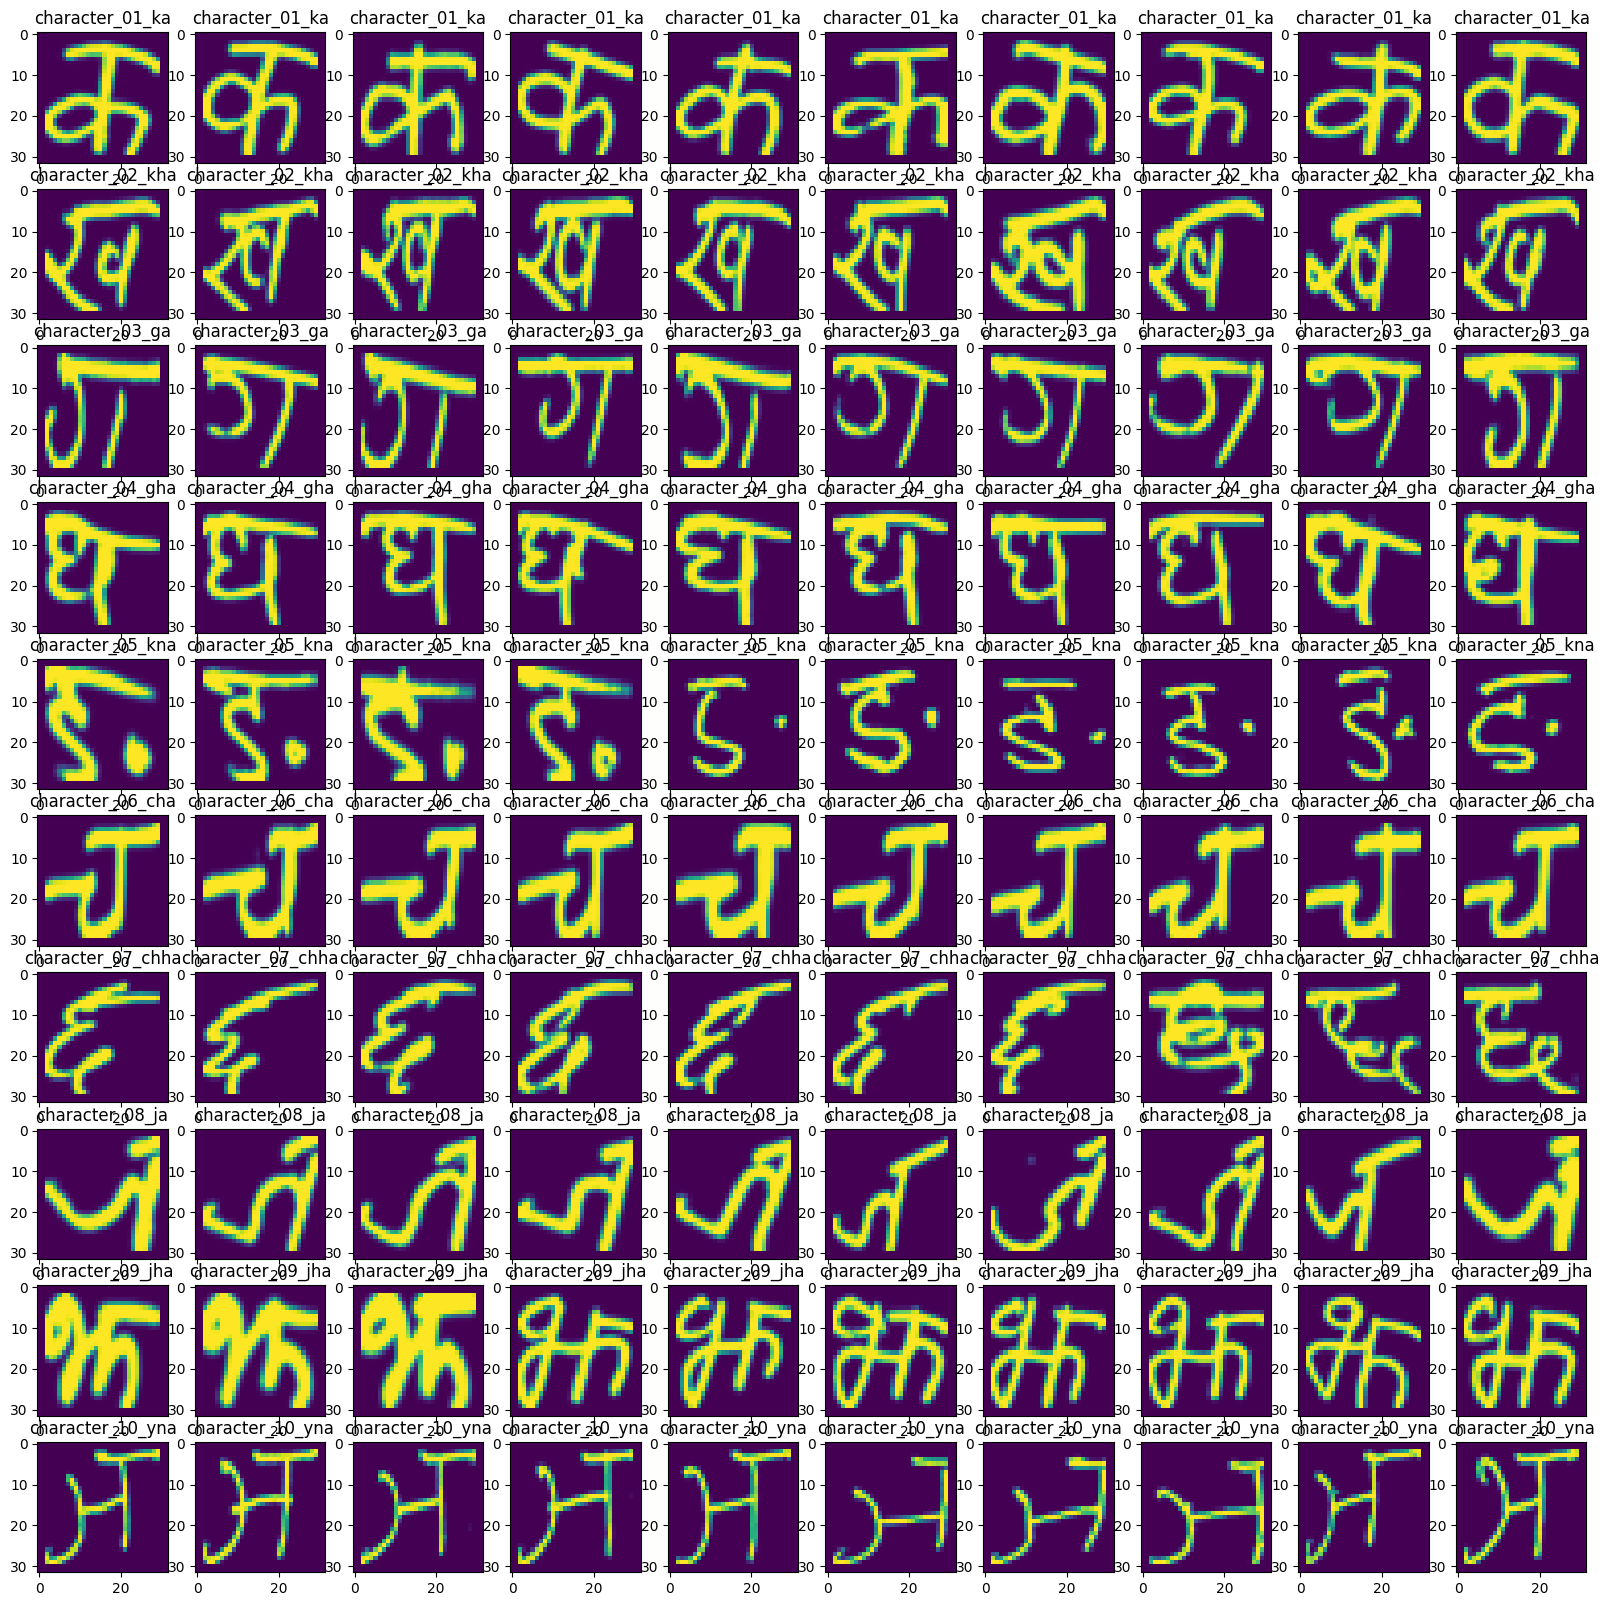

In [ ]:
from PIL import Image
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
_ = plt.imshow(Image.open(f"Conditional_DCGAN_epoch_{NUM_EPOCH}.jpg"))



### Plot for Discriminator and Generator loss over the epochs

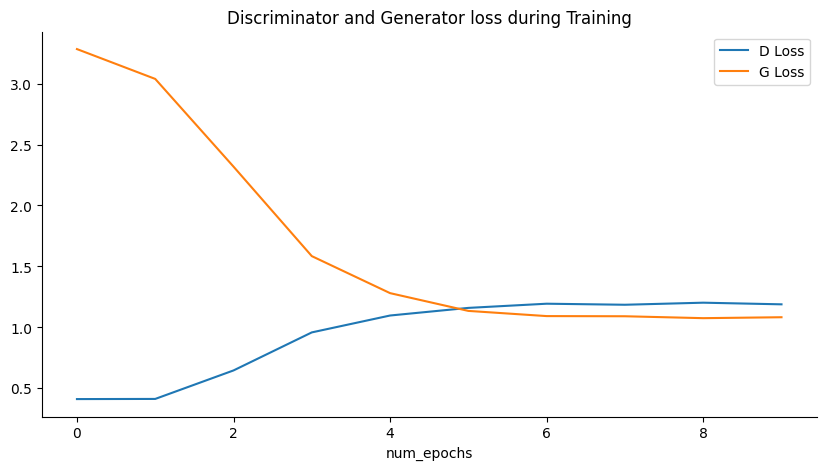

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Discriminator and Generator loss during Training")
# plot Discriminator and generator loss
plt.plot(D_losses,label="D Loss")
plt.plot(G_losses,label="G Loss")
# get plot axis
ax = plt.gca()
# remove right and top spine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# add labels and create legend
plt.xlabel("num_epochs")
plt.legend()
plt.show()

In [44]:
def get_model_resnet18(n_class):
    model = torchvision.models.resnet18( weights=torchvision.models.ResNet18_Weights.DEFAULT)
    model.conv1=torch.nn.Conv2d(1 ,64, kernel_size=(7,7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = torch.nn.Linear(model.fc.in_features, n_class)
    #torch.nn.Softmax(dim=1)
    model = model.to(device)
    return model
model_resnet18 = get_model_resnet18(train_set.classes.shape[0])
print(model_resnet18)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [45]:
def train_and_evaluate_classifier(model):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
  criterion = torch.nn.CrossEntropyLoss()
  loss_list, t, train_a, test_a = model_training(
  model, criterion, optimizer, trainloader, testloader, num_epochs=10)
  plot_training_graphs(loss_list)
  model.eval()
  with torch.no_grad():
      test_labels = []
      test_output = []
      for batch_idx, batch in enumerate(testloader):
          x, y = batch
          x, y = x.to(device), y.to(device)
          y_hat = model(x)
          test_labels += y.cpu()
          test_output += torch.argmax(y_hat, dim=1).cpu()

      test_labels = np.array(test_labels)
      test_output = np.array(test_output)
      metric = confusionMatrixAndAccuracyReport(
          test_labels, test_output, test_set.classes, title=f'Resnet18')

Epoch: 1 (0m 58s) 	Training Loss: 2.827, 	Test Loss: 1.724,  	Training acc: 0.295, 	Test acc: 0.551, 
Epoch: 2 (1m 57s) 	Training Loss: 1.171, 	Test Loss: 0.734,  	Training acc: 0.687, 	Test acc: 0.797, 
Epoch: 3 (2m 57s) 	Training Loss: 0.568, 	Test Loss: 0.410,  	Training acc: 0.840, 	Test acc: 0.884, 
Epoch: 4 (3m 58s) 	Training Loss: 0.348, 	Test Loss: 0.265,  	Training acc: 0.900, 	Test acc: 0.925, 
Epoch: 5 (5m 2s) 	Training Loss: 0.238, 	Test Loss: 0.184,  	Training acc: 0.931, 	Test acc: 0.948, 
Epoch: 6 (6m 4s) 	Training Loss: 0.172, 	Test Loss: 0.135,  	Training acc: 0.950, 	Test acc: 0.961, 
Epoch: 7 (7m 8s) 	Training Loss: 0.131, 	Test Loss: 0.104,  	Training acc: 0.962, 	Test acc: 0.971, 
Epoch: 8 (8m 13s) 	Training Loss: 0.101, 	Test Loss: 0.079,  	Training acc: 0.971, 	Test acc: 0.978, 
Epoch: 9 (9m 19s) 	Training Loss: 0.079, 	Test Loss: 0.062,  	Training acc: 0.977, 	Test acc: 0.982, 
Epoch: 10 (10m 24s) 	Training Loss: 0.064, 	Test Loss: 0.051,  	Training acc: 0.982, 

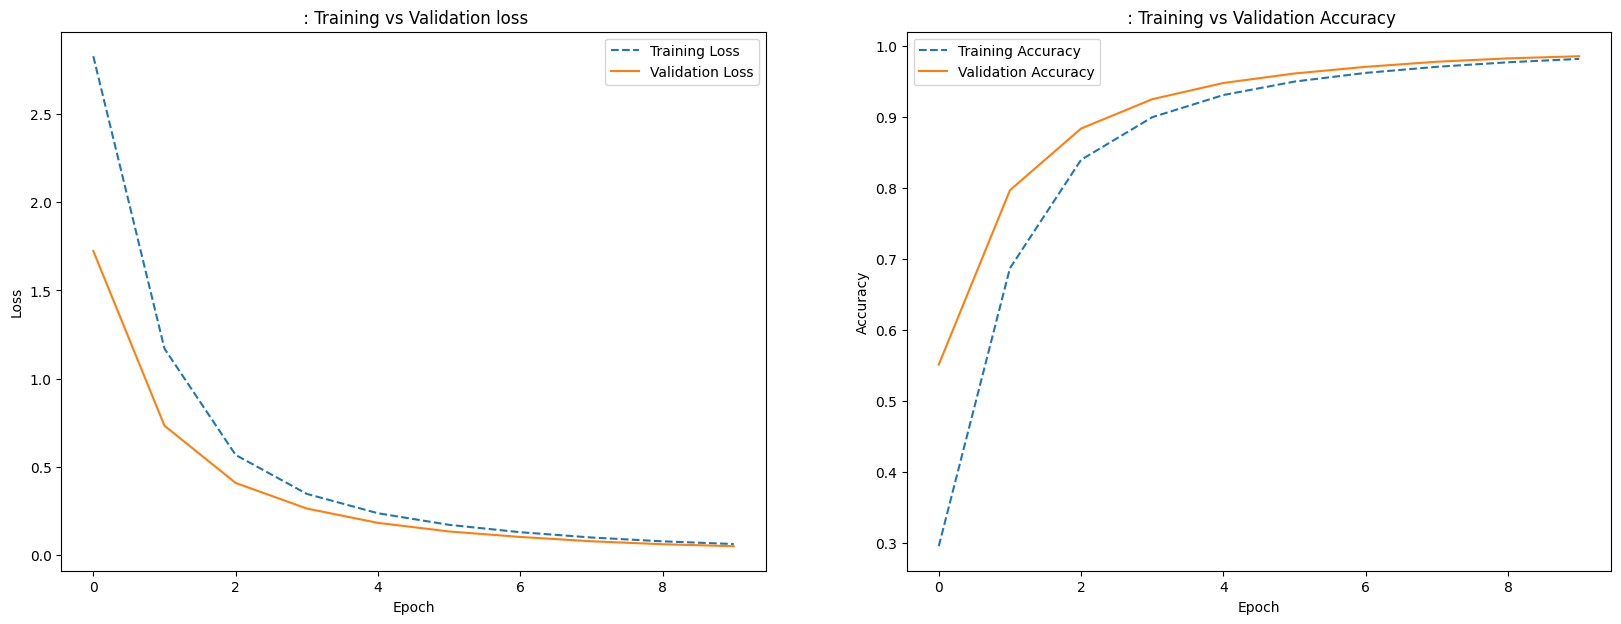

<Figure size 640x480 with 0 Axes>

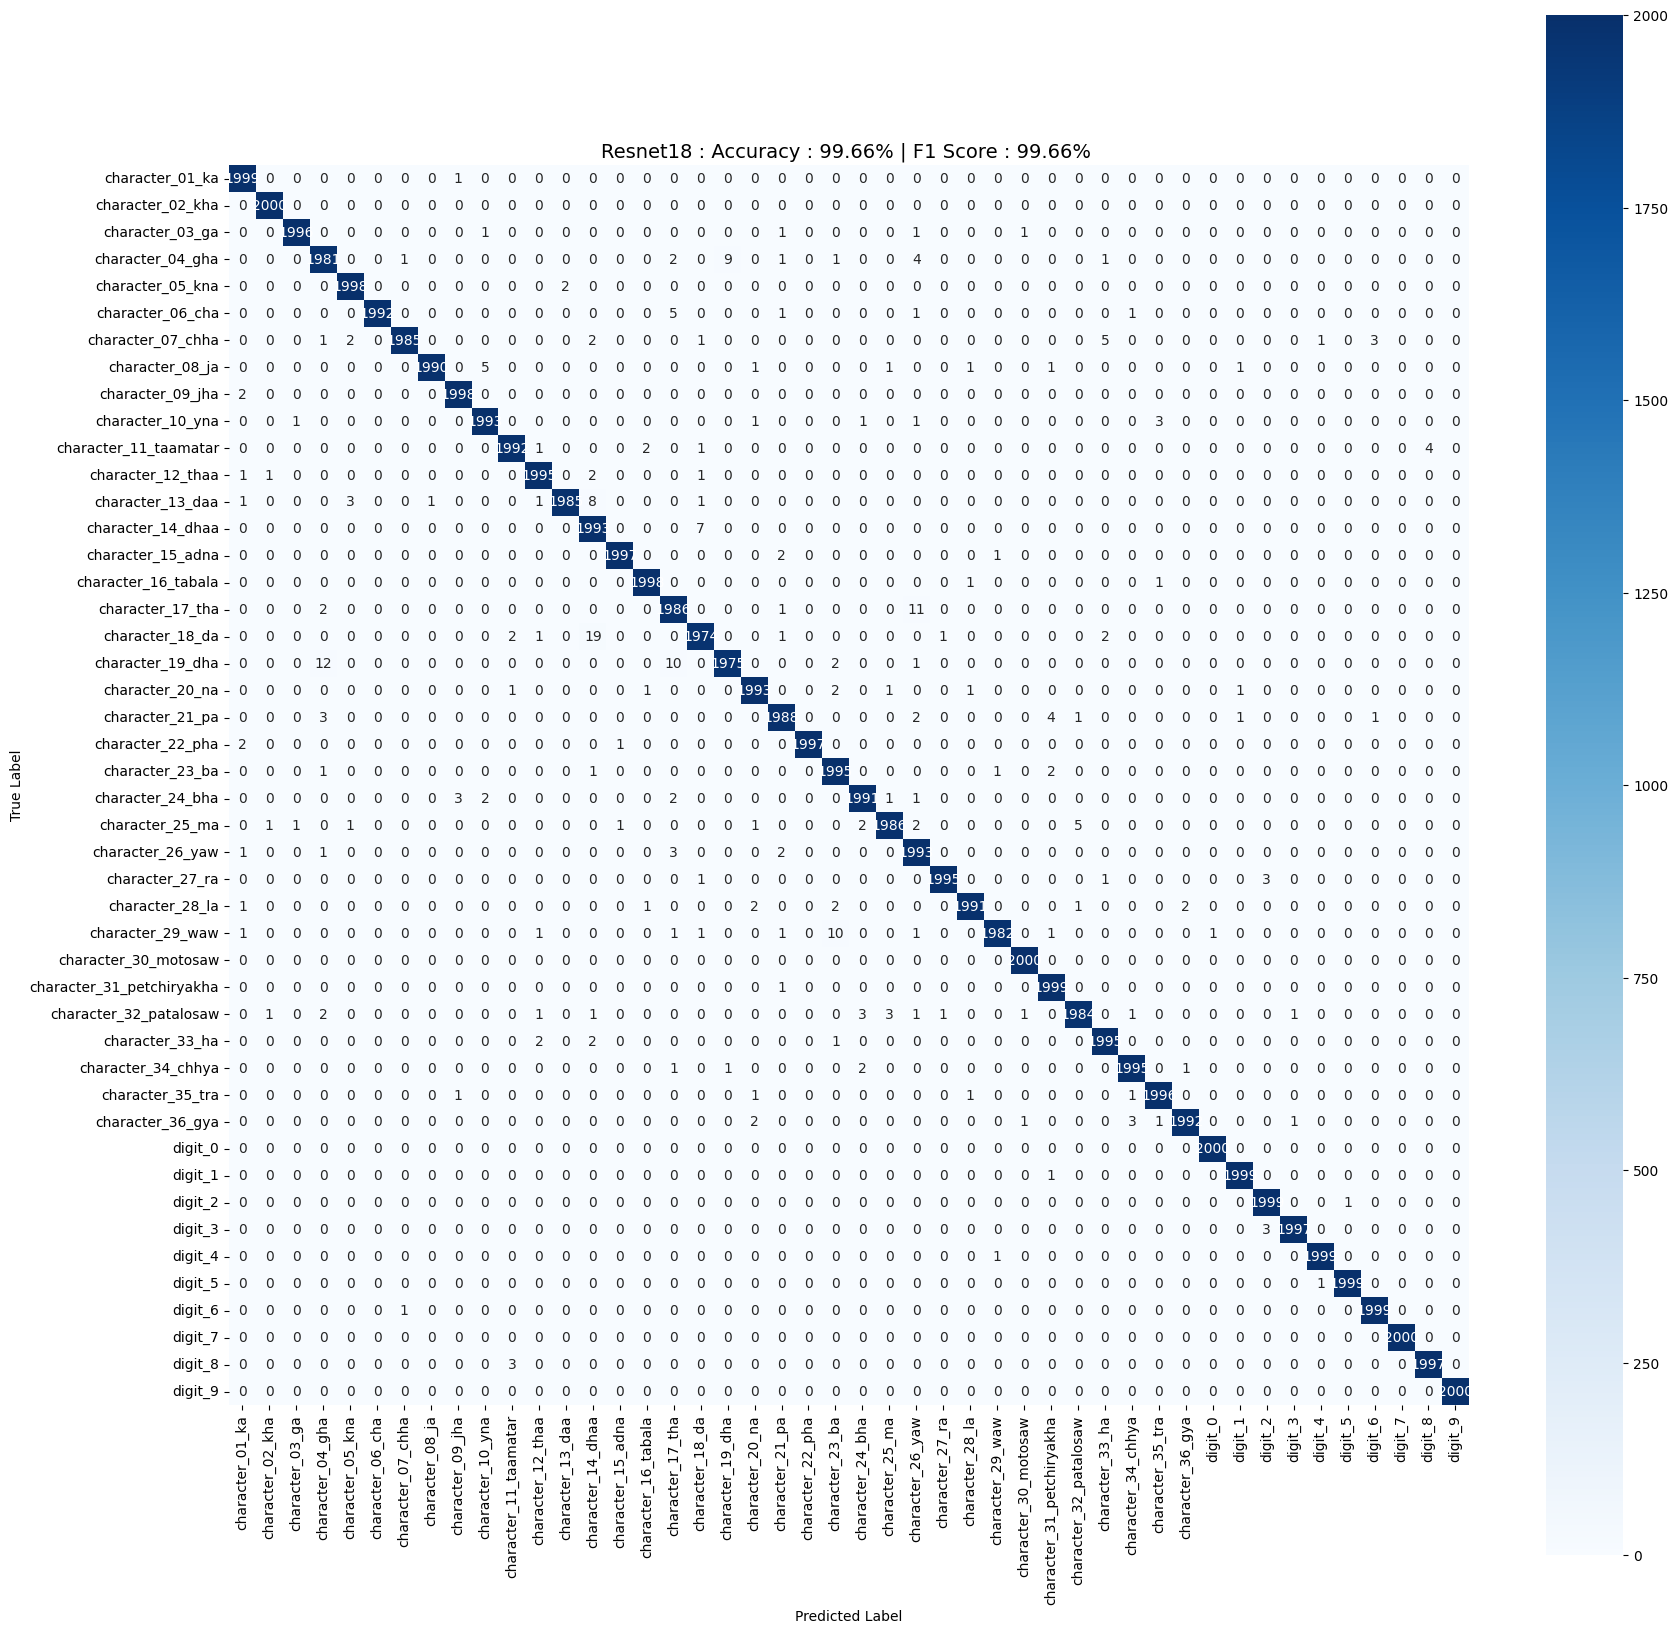

Accuracy: 99.661%
F1 Score: 99.661%

Classwise Accuracy Score: 
|   character_01_ka |   character_02_kha |   character_03_ga |   character_04_gha |   character_05_kna |   character_06_cha |   character_07_chha |   character_08_ja |   character_09_jha |   character_10_yna |   character_11_taamatar |   character_12_thaa |   character_13_daa |   character_14_dhaa |   character_15_adna |   character_16_tabala |   character_17_tha |   character_18_da |   character_19_dha |   character_20_na |   character_21_pa |   character_22_pha |   character_23_ba |   character_24_bha |   character_25_ma |   character_26_yaw |   character_27_ra |   character_28_la |   character_29_waw |   character_30_motosaw |   character_31_petchiryakha |   character_32_patalosaw |   character_33_ha |   character_34_chhya |   character_35_tra |   character_36_gya |   digit_0 |   digit_1 |   digit_2 |   digit_3 |   digit_4 |   digit_5 |   digit_6 |   digit_7 |   digit_8 |   digit_9 |
|------------------:|---------------

<Figure size 640x480 with 0 Axes>

In [46]:
train_and_evaluate_classifier(model_resnet18)